# Getting Started with the Arize Platform - Investigating Prediction Drift

**In this walkthrough, we are going to investigate prediction drift and get to the bottom of why it happened.** 

Our steps will be :

1. Setup drift monitors and identify prediction drift
2. Figure out which features are drifting and causing the prediction drift

# Setup and Getting the Data 

In this walkthrough, we are going to be looking at the Lending Club dataset and predicting whether loans are good or bad. We will load in some preexisting data - training data, test data, and predictions. Using a preexisting model saves time in this example, but also illustrates how simple it is to plug into the Arize platform.


###Install Dependencies and Import Libraries 📚

In [ ]:
!pip install arize -q
!pip install tables --upgrade -q

import pandas as pd
import requests
import io
from arize.types import ModelTypes

print("✅ Dependencies installed and libraries imported!")

     |████████████████████████████████| 1.3MB 5.4MB/s 
     |████████████████████████████████| 286kB 33.1MB/s 
ERROR: tensorflow-metadata 0.30.0 has requirement googleapis-common-protos<2,>=1.52.0, but you'll have googleapis-common-protos 1.51.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 4.3MB 2.9MB/s 
✅ Dependencies installed and libraries imported!


### Download the Data 🌐
For our model we have **3 Environments**: training, validation, and production. We download each of them, storing them in a dictionary `datasets` for later use. We also download SHAP values.

In [ ]:
environments = ['training', 'validation', 'production']
datasets = {}

for environment in environments:
  
  url = 'https://storage.googleapis.com/arize-assets/fixtures/value_showcase_' + environment + '_data.h5'
  r = requests.get(url)
  with open('value_showcase_' + environment + '_data.h5', 'wb') as f:
      f.write(r.content)

  # Create the dataframe and store in dictionary
  datasets[environment] = pd.read_hdf('value_showcase_' + environment + '_data.h5')

# Download the SHAP data to a local file
url = 'https://storage.googleapis.com/arize-assets/fixtures/value_showcase_production_shap.h5'
r = requests.get(url)
with open('value_showcase_production_data_shap.h5', 'wb') as f:
    f.write(r.content)

# Create the SHAP dataframe
lending_data_shap_df = pd.read_hdf("value_showcase_production_data_shap.h5")

features = ['loan_amount',	'term',	'interest_rate',	'installment',	'grade',	'home_ownership',	'annual_income',	'verification_status',	'pymnt_plan',	'purpose',	'addr_state',	'dti',	'delinq_2yrs',	'inq_last_6mths',	'mths_since_last_delinq',	'mths_since_last_record',	'open_acc',	'pub_rec',	'revol_bal',	'actuals',	'predictions',	'fico_score',	'fico_range']

print("✅ Data successfully downloaded!")

✅ Data successfully downloaded!


# Sending Data into Arize 💫

Now that we have our data configured, we are ready to integrate into Arize 

For our model, we are going to log:


*   feature data
*   predictions
*   actuals
*   SHAP values for explainability metrics

The first step is to setup our Arize client. After that we will log the data.





## Import and Setup Arize Client

You can find your `API_KEY` and `ORGANIZATION_KEY` at on your [Settings Page](https://app.arize.com/admin). Copy those over to the set-up section. We will also be setting up some metadata to use across all logging.
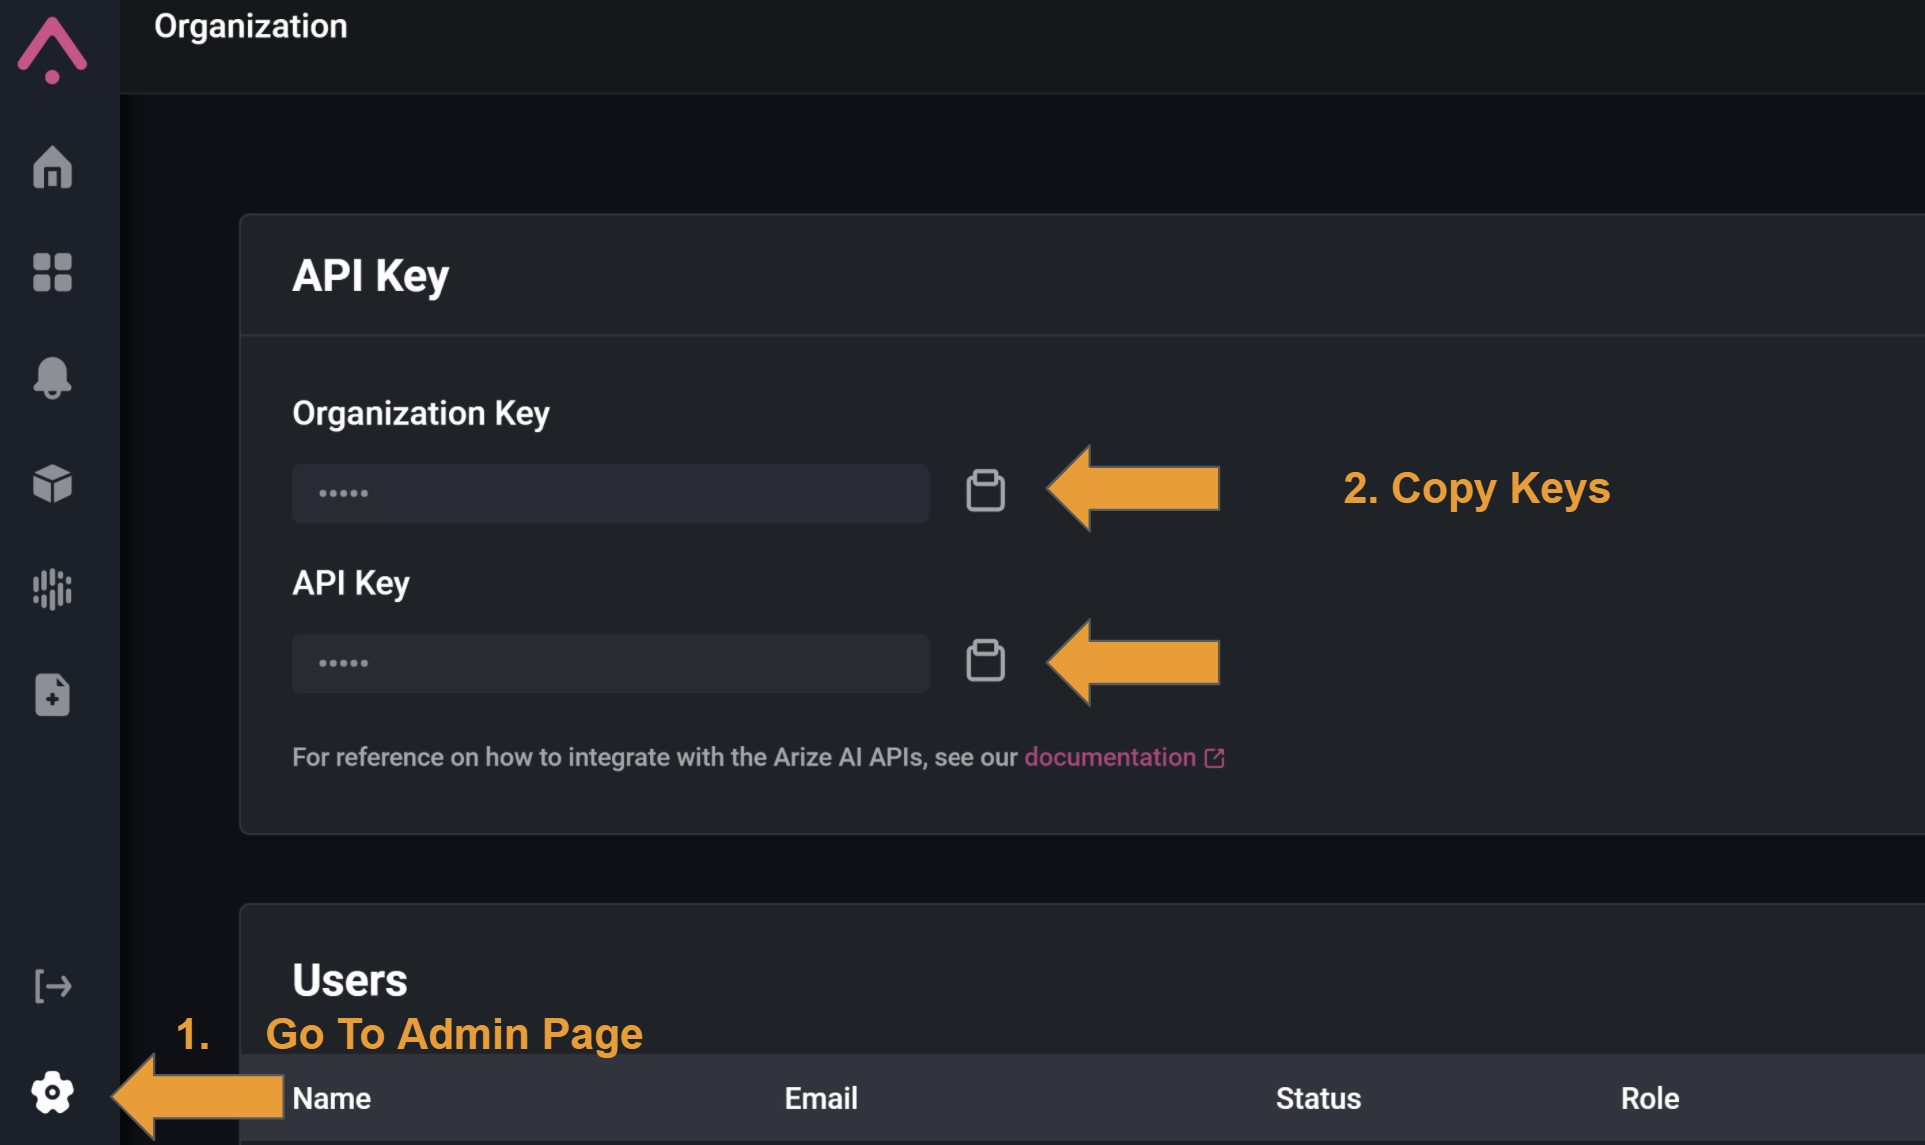

In [ ]:
from arize.api import Client
from arize.types import ModelTypes 

ORGANIZATION_KEY = 'ORGANIZATION_KEY'
API_KEY = 'API_KEY'
arize = Client(organization_key=ORGANIZATION_KEY, api_key=API_KEY)

model_id = 'lending-club-performance-dip-tutorial' # This is the model name that will show up in Arize
model_version = 'v1.0' # Version of model - can be any string

if (ORGANIZATION_KEY == 'ORGANIZATION_KEY' or API_KEY == 'API_KEY'): 
  raise ValueError("❌ NEED TO CHANGE ORGANIZATION AND/OR API_KEY")
else: 
  print("✅ Arize setup complete!")

✅ Arize setup complete!


## Log the Prediction Data
Now that our Arize client is setup, let's go ahead and log all of our data to the platform.

In [ ]:
# Logging Training Data
training_dataset = datasets['training']
responses = arize.log_training_records(
    model_id=model_id + "-" + model_version,
    model_version=model_version,
    model_type=ModelTypes.SCORE_CATEGORICAL,
    prediction_labels=training_dataset['predictions'],
    prediction_scores=training_dataset['predictions_score'],
    actual_labels=training_dataset['actuals'],
    features=training_dataset[features],
    )

# Logging Validation Data
validation_dataset = datasets['validation']
responses = arize.log_validation_records(
    batch_id = str(1),
    model_id=model_id + "-" + model_version,
    model_version=model_version,
    model_type=ModelTypes.SCORE_CATEGORICAL,
    prediction_labels=validation_dataset['predictions'],
    prediction_scores=validation_dataset['predictions_score'],
    actual_labels=validation_dataset['actuals'],
    features=validation_dataset[features],
    )

# Logging Production Data
production_dataset = datasets['production']
log_bulk_responses = arize.bulk_log(
    model_id=model_id + "-" + model_version,
    model_version=model_version,
    model_type=ModelTypes.SCORE_CATEGORICAL,
    prediction_ids=production_dataset['prediction_ids'],
    prediction_labels=pd.DataFrame({'prediction_labels': production_dataset['predictions'], 'prediction_scores': production_dataset['predictions_score']}),
    actual_labels=production_dataset['actuals'],
    prediction_timestamps=production_dataset['model_date'].apply(lambda t: int(t.timestamp())),
    shap_values=lending_data_shap_df,
    features=production_dataset[features]
)

print("✅ Data successfully logged to Arize!")

✅ Data successfully logged to Arize!


## Coffee Time! ☕️
Note that because of the indexing Arize performs on data load, there's a delay before data appears on the platform. While the model should appear immediately, the data may take up to 10 minutes to show up. Feel free to go grab a cup of coffee as Arize works its magic! 🔮

**⚠️ Important:** 
In order to move on to the next step, make sure your actuals and training/validation sets are loaded into the platform. To check:
1. On the **Overview Tab** make sure you see the actuals.

2. On the **Datasets** tab and make sure you see in the *Environment* column one for *Training* and *Validation* as shown below.

1 - actuals present 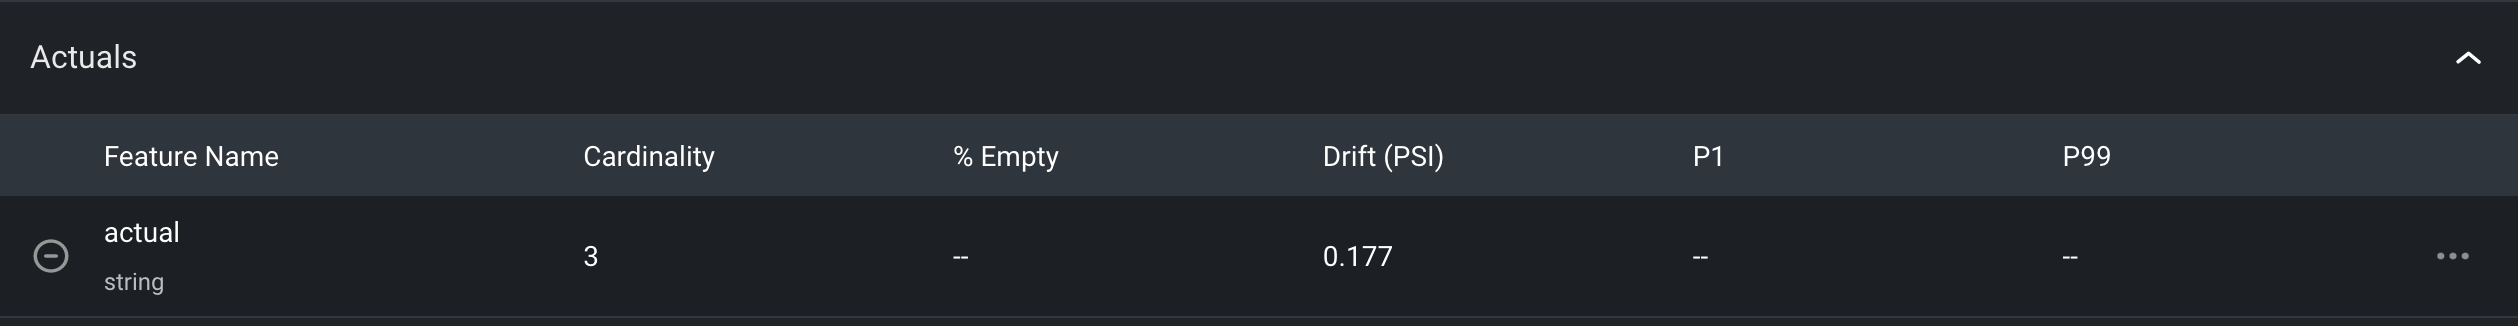

2 - training and validation sets present 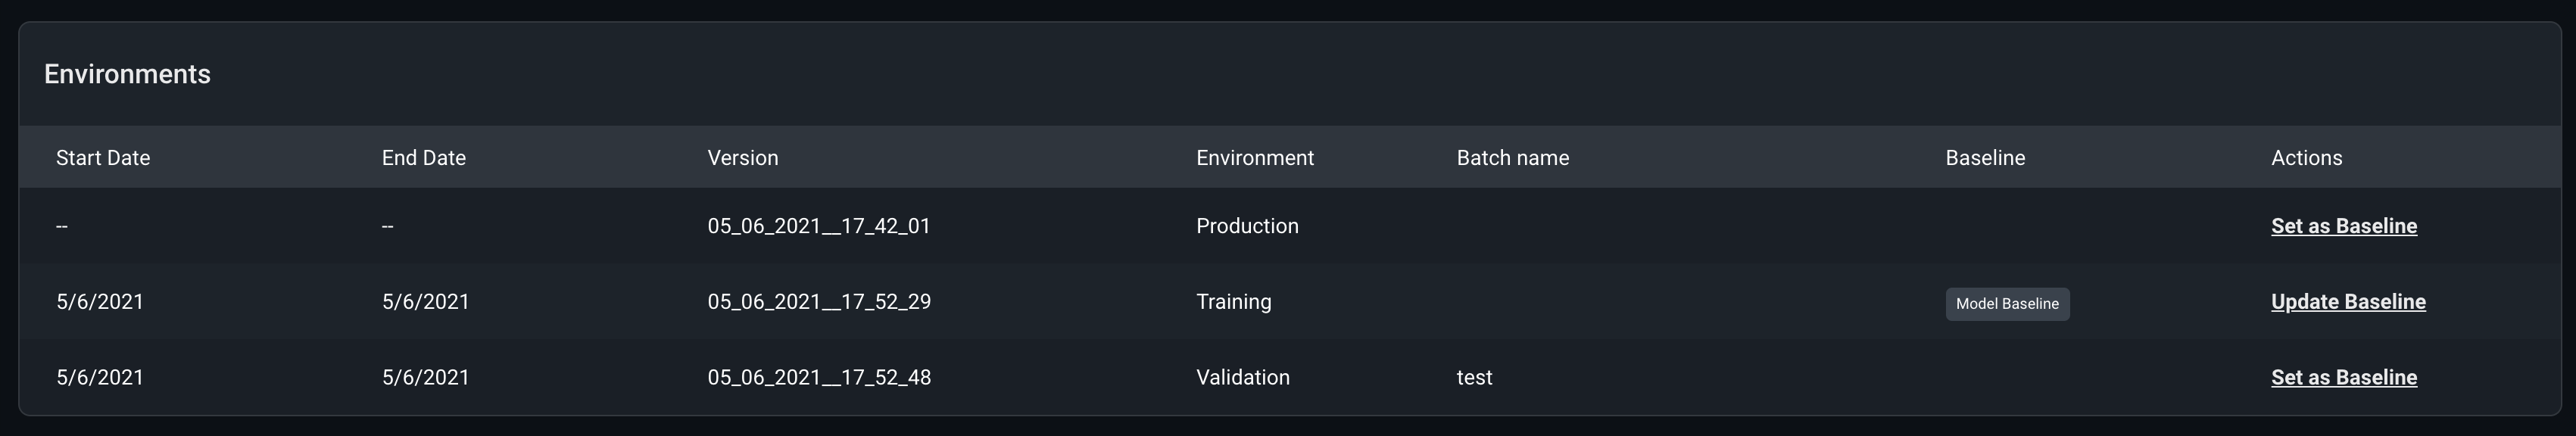

# Explore the Platform  🔎

Welcome back! Now we can go take a look at the [Arize platform](https://app.arize.com/) and take a look at the logged data. Head over to the **Models** page and select our newly created model `lending-club-tutorial`.



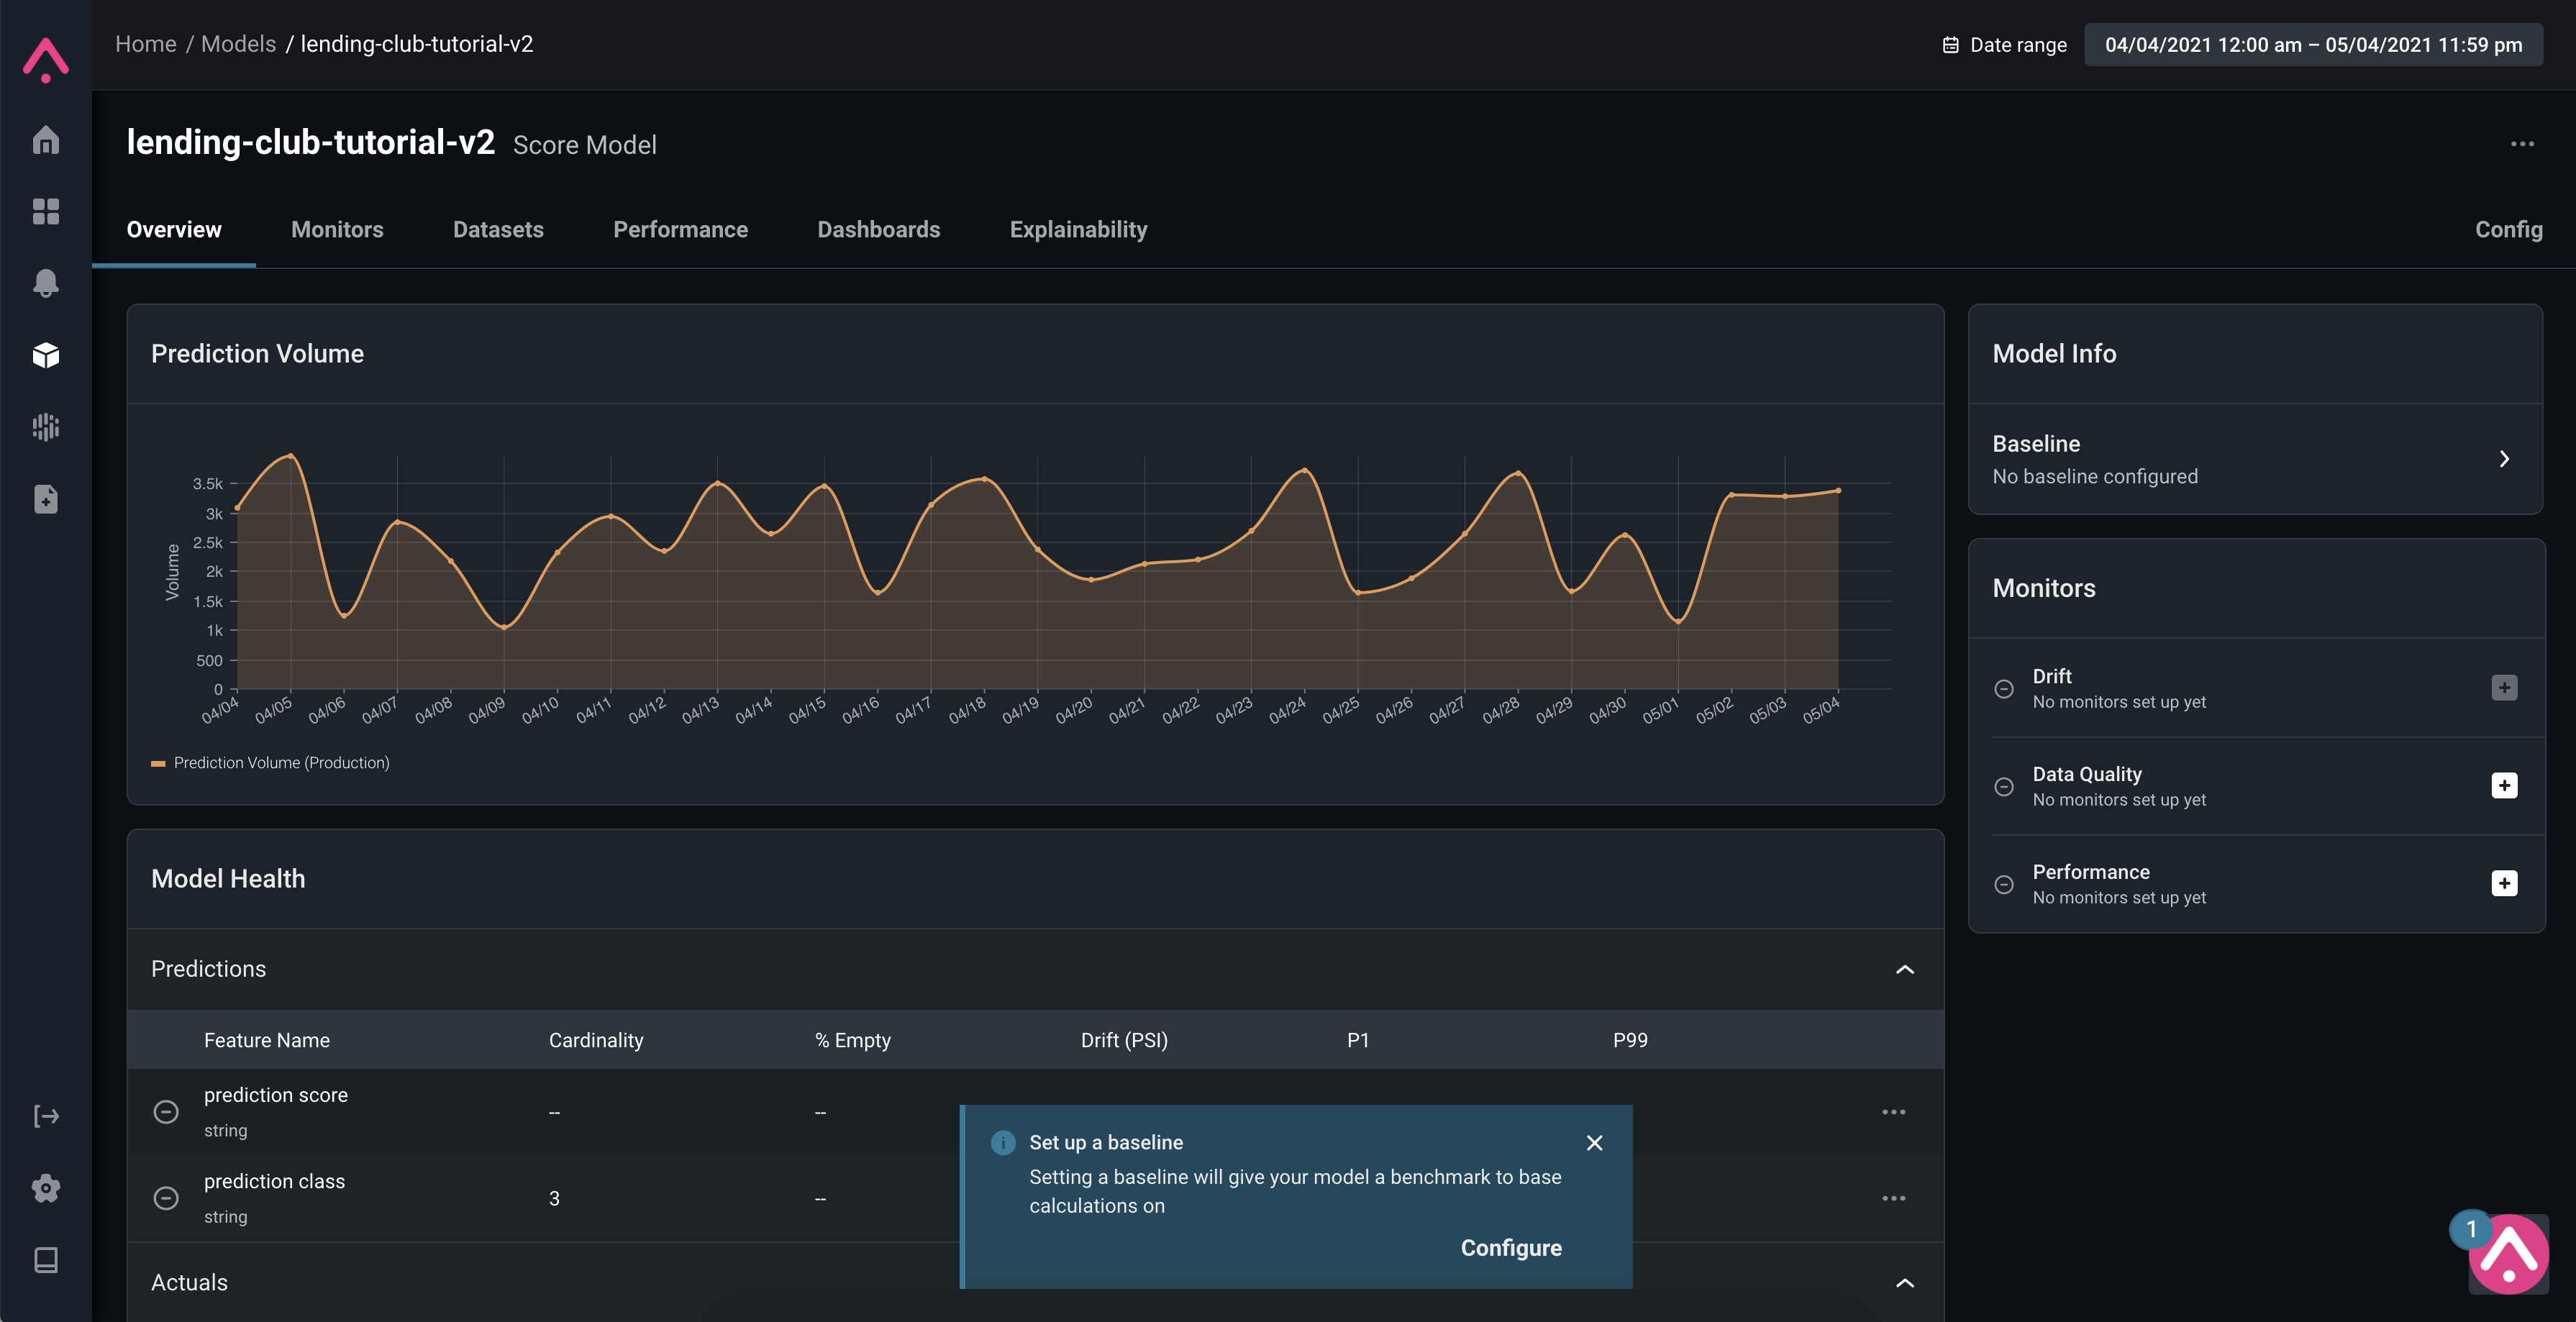

### Setting up a Baseline

One of the first steps for drift analysis is to set up a baseline to compare your model to. Go ahead and click on the **Configure** button in the bottom popup, or by going to the **Baseline** button on the right side of the screen. We're going to set the training data as our baseline to compare our model to. Follow the below guide to set up this baseline.

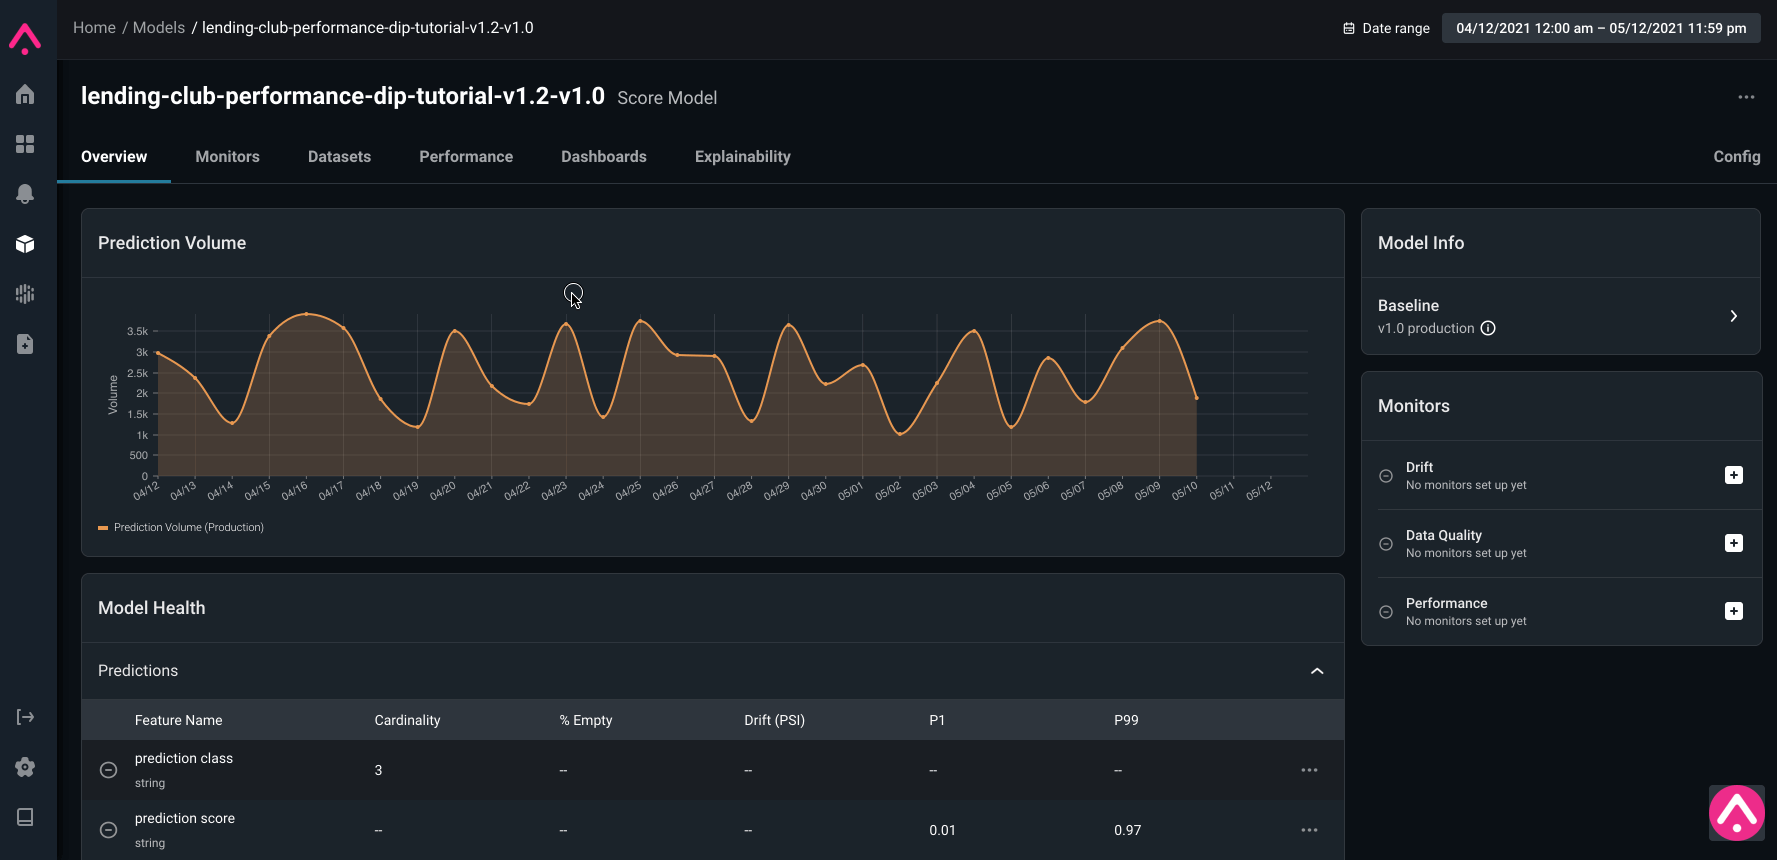

### Creating Drift Monitors

Now that we have our baseline configured, we can look at metrics such as drift. Take a look at the PSI (drift) for the prediction drift score. Notice how it's quite high and a warning icon is displayed next to it. Let's start our investigation of this drift issue by creating drift monitors for predictions and all features. You can create all of them in one click by pressing on the plus button next to *Drift*.

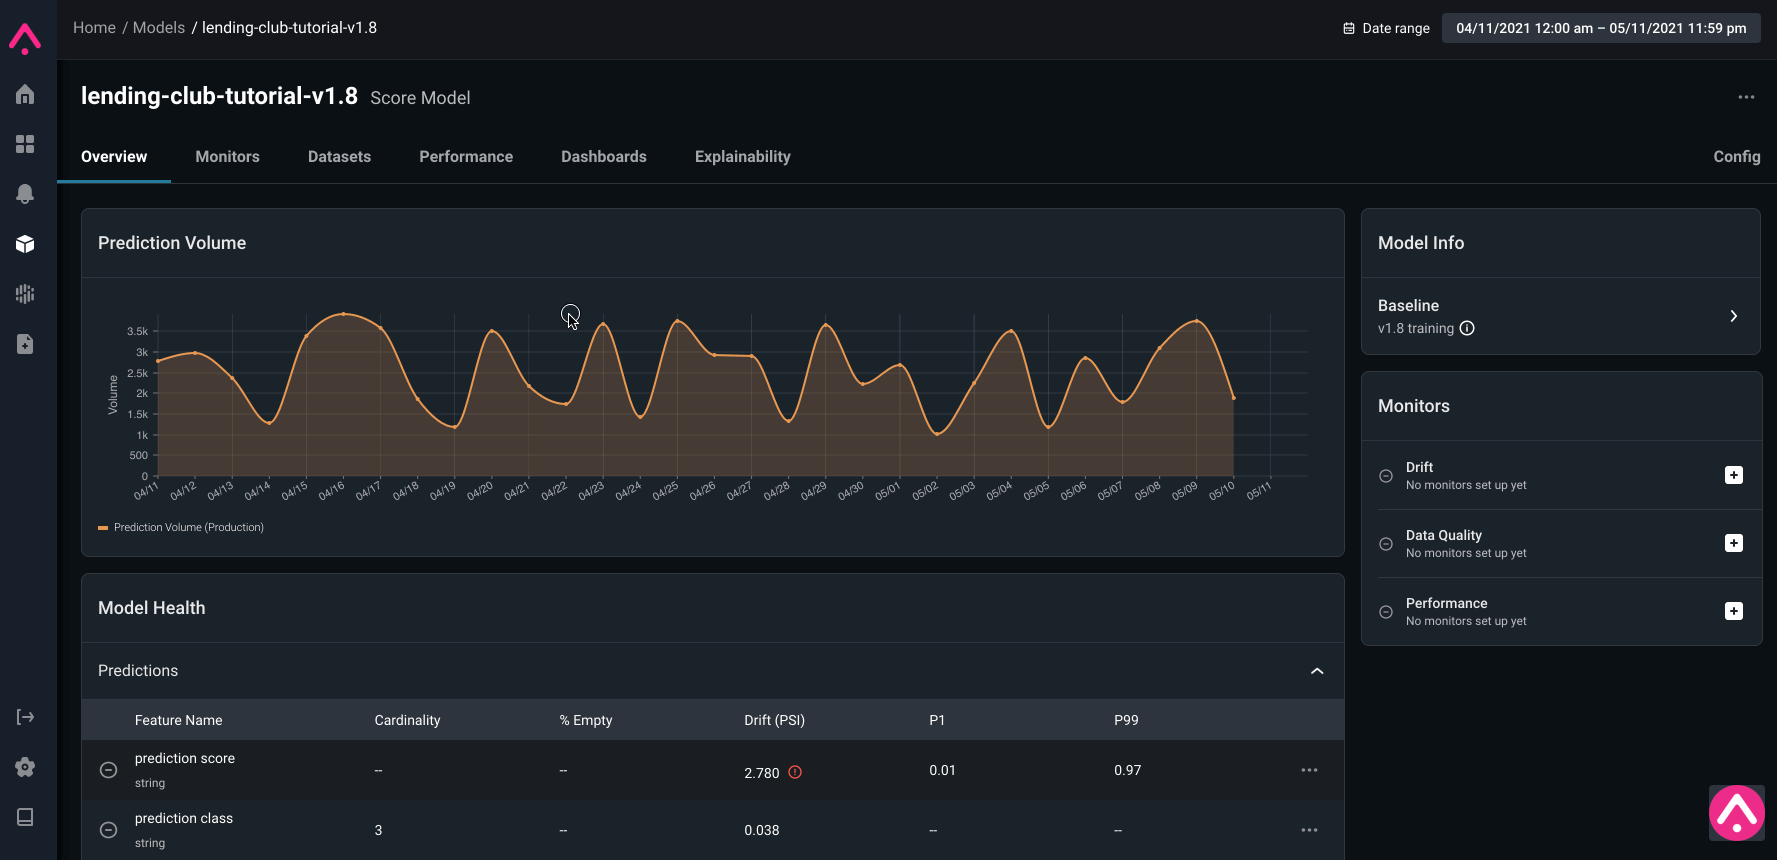

Now let's click into the prediction drift monitor and take a look at the data. While the model is just peaking above our threshold right now, we see a dangerous upwards trend in prediction drift.

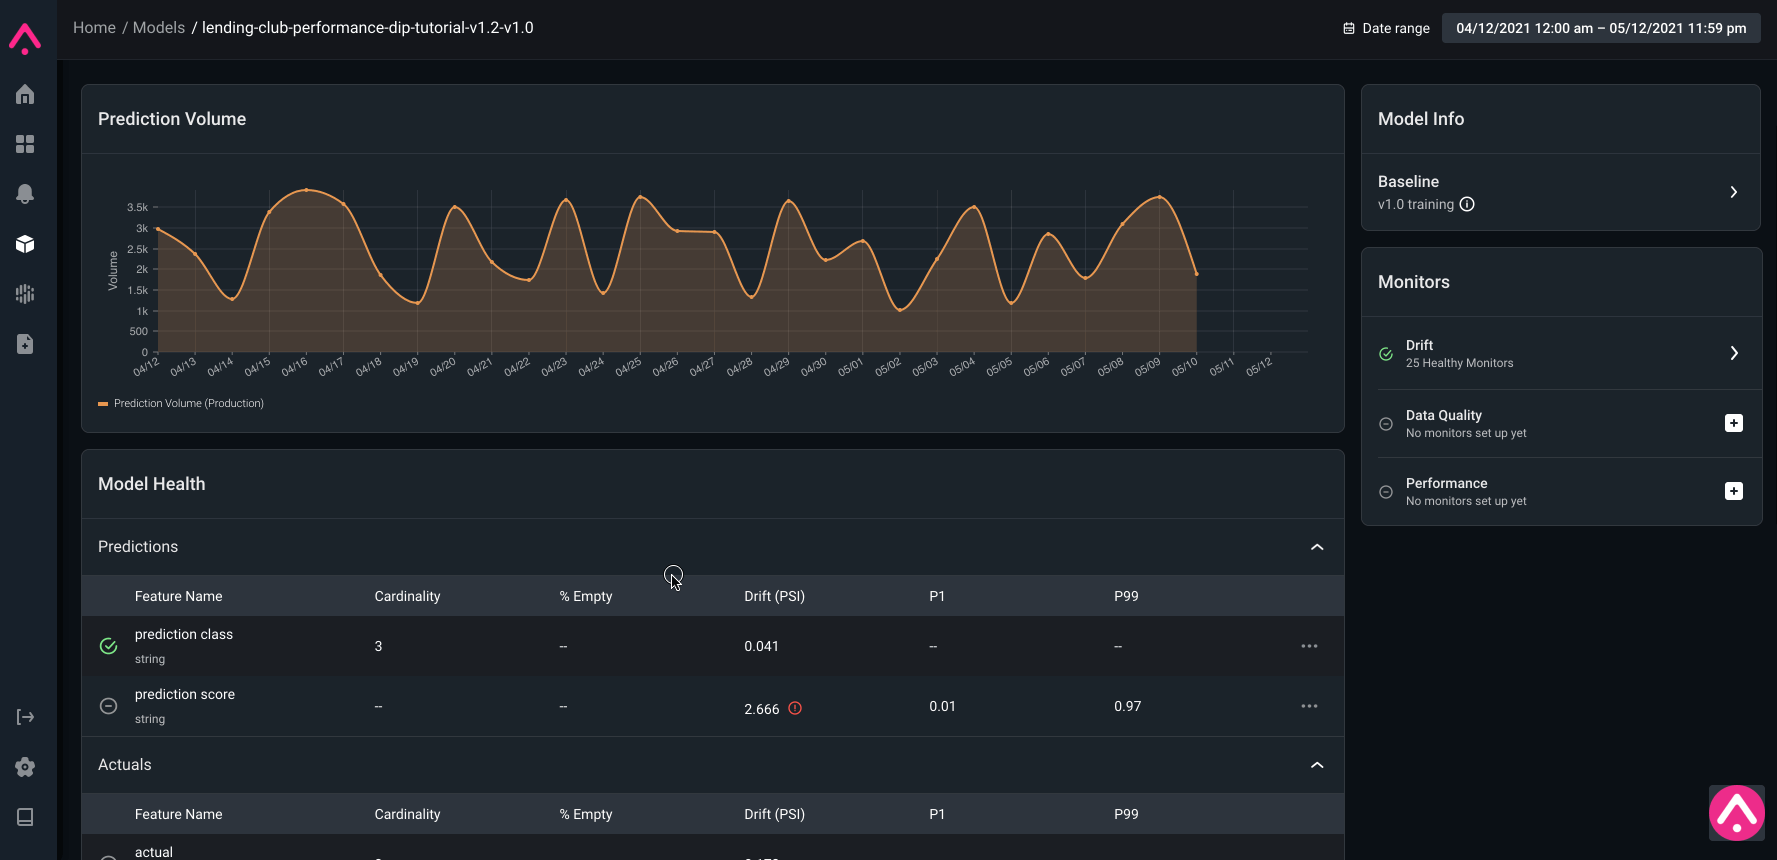

Let's explore what could be causing this prediction drift. One potential source is individual feature drifts. Scroll down on the **Overview** page and take a look at the features section. Let's sort by Drift to see our features with the highest drift values.

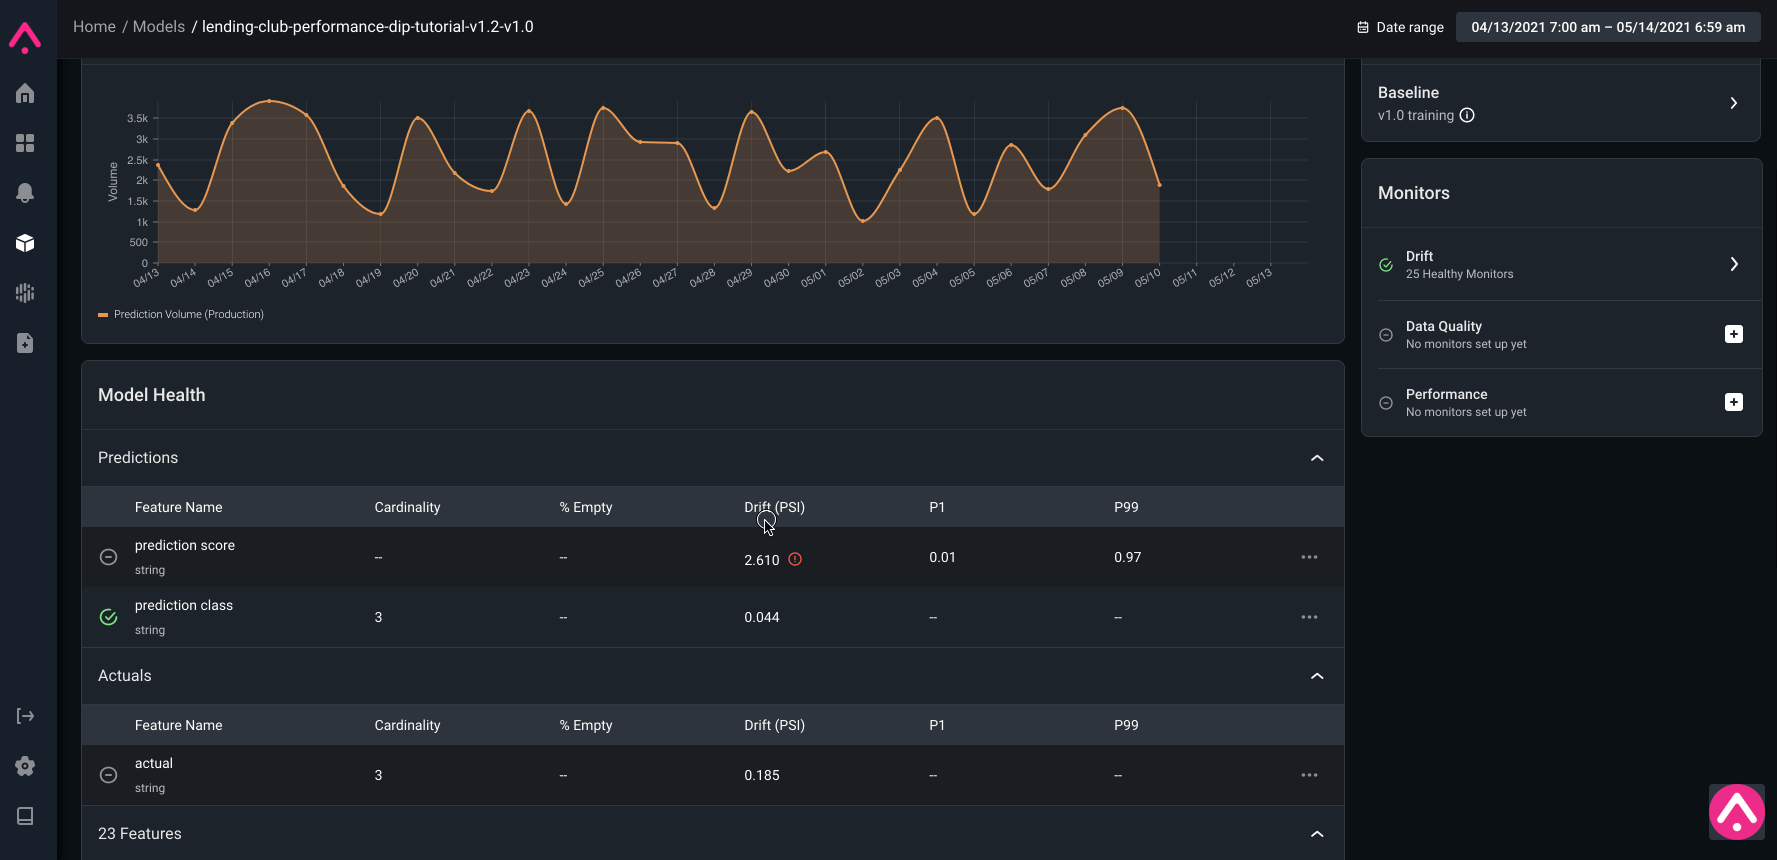

It looks a number of other features exhibit fairly high drift values. Let's take a look at the `annual_income` which has the highest PSI. Click the monitor icon on the `annual income` row to go into its drift monitor page.

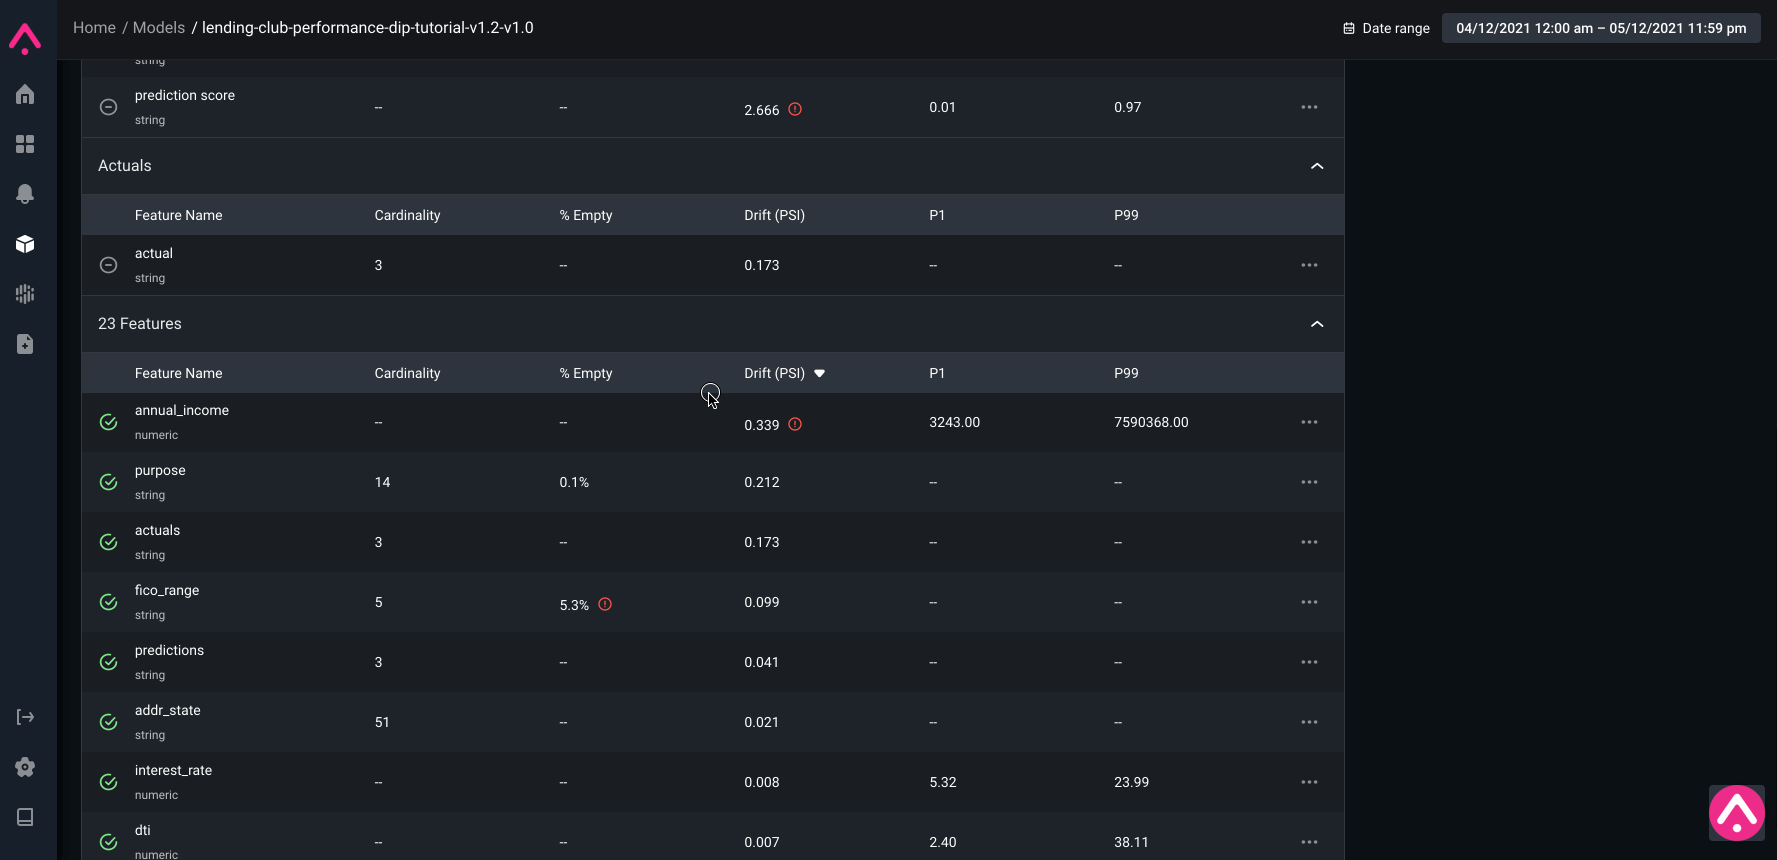

This monitor view allows you to see both the drift over time, as well as the difference between the current and baseline distribution. As you can see, there is a huge ramp-up in drift for the `annual_income` feature.

With this information, it seems quite possible that an increase in feature drift for `annual_income` and perhaps a number of other features is responsible for our prediction drift. Looking into why these features drifted is paramount in maintaining a healthy and relevant model.

# Wrap Up 🎁

In this walkthrough we've shown how Arize can be used to log prediction data for a model, discover prediction and feature drift, and set up monitors to catch future issues. Though we covered a lot of ground, this is just scratching the surface of what the Arize platform can do. We urge you to explore more of Arize, either on your own or through one of our many other tutorials.